# Сборный проект-5

Данный проект посвящен разработке демонстрационной версии поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## Подключение необходимых библиотек

In [1]:
!pip install wordcloud -q

In [2]:
!pip install scikit-learn -q

In [3]:
!pip install catboost -q

In [4]:
# Подключение необходимых библиотек
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import nltk
import spacy
import re
import keras_nlp

from PIL import Image

from pathlib import Path

from tqdm.notebook import tqdm
tqdm.pandas()

from wordcloud import WordCloud
from nltk.corpus import stopwords as nltk_stopwords

import tensorflow as tf
from tensorflow.keras.layers import (Dense, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow import keras

import torchvision.models as models
import torch
import torch.nn as nn

import random
from transformers import BertTokenizer, BertModel


from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV, cross_val_score
from catboost import CatBoostRegressor

In [5]:
nltk.download('stopwords')
stopwords = set(nltk_stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
PATH = '/content/drive/MyDrive/Colab Notebooks/to_upload'
RANDOM_STATE = 42
SEED = 42

## 1 **Загрузка и предварительный обзор данных**


Выполним загрузку доступных датафреймов и проверим их содержимое.

Согласно условиям задания, нам доступны следующие данные:

- train_dataset.csv находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания.
- CrowdAnnotations.tsv — данные по соответствию изображения и описания, полученные с помощью краудсорсинга.
- ExpertAnnotations.tsv содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов.
- test_queries.csv находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение.

Также есть две папки с изображениями:

- train_images содержит изображения для тренировки модели.
- test_images содержит изображения для тестирования модели.

In [8]:
# Создадим вспомогательную функцию, которая выводит первые три строчки датасета и общую информацию о его содержимом

def data_info(df):
    print ('Первые три строчки датасета:')
    display(df.head(3))
    print ('\n','Общая информация о датасете:','\n')
    display(df.info())

### 1.1 **Загрузка текстовых данных для тренировки и тестирования**

Датафрейм train_dataset.csv с информацией, необходимой для обучения: имя файла изображения, идентификатор описания и текст описания

In [9]:
# Датафрейм с информацией, необходимой для обучения: имя файла изображения, идентификатор описания и текст описания
train_dataset = pd.read_csv(PATH + '/train_dataset.csv', sep = ',')

In [10]:
data_info(train_dataset)

Первые три строчки датасета:


image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...


 Общая информация о датасете: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


None

Файл `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

In [11]:
names_crowd = ['image', 'query_id', 'agreed_ratio','number_agreed','number_disagreed']
crowd_annotations = pd.read_csv(PATH + '/CrowdAnnotations.tsv', sep = '\t', header = None, names = names_crowd)
data_info(crowd_annotations)

Первые три строчки датасета:


image                     query_id  agreed_ratio  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2           1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2           0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2           0.0   

   number_agreed  number_disagreed  
0              3                 0  
1              0                 3  
2              0                 3


 Общая информация о датасете: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   image             47830 non-null  object 
 1   query_id          47830 non-null  object 
 2   agreed_ratio      47830 non-null  float64
 3   number_agreed     47830 non-null  int64  
 4   number_disagreed  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None

In [12]:
len(crowd_annotations['image'].unique())

1000

Файл `ExpertAnnotations.tsv` с данными по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

In [13]:
names_expert = ['image', 'query_id', 'exp1','exp2','exp3']
expert_annotations = pd.read_csv(PATH + '/ExpertAnnotations.tsv', sep = '\t', header = None, names = names_expert)
data_info(expert_annotations)

Первые три строчки датасета:


image                     query_id  exp1  exp2  exp3
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     1     1     1
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2     1     1     2
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2     1     1     2


 Общая информация о датасете: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5822 non-null   object
 1   query_id  5822 non-null   object
 2   exp1      5822 non-null   int64 
 3   exp2      5822 non-null   int64 
 4   exp3      5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB


None

Информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение - датафрейм test_queries

In [14]:
# Информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение
test_queries = pd.read_csv(PATH + '/test_queries.csv',  sep = '|', index_col=0)
data_info(test_queries)

Первые три строчки датасета:


query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg


 Общая информация о датасете: 

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


None

In [15]:
# Датафрейм с именами файлов из папки с тестовыми изображениями
test_images = pd.read_csv(PATH + '/test_images.csv')

In [16]:
data_info(test_images)

Первые три строчки датасета:


image
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg


 Общая информация о датасете: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   image   100 non-null    object
dtypes: object(1)
memory usage: 932.0+ bytes


None

Данные с описанием изображений и оценками содержимого загружены корректно, содержимое соответствует ожиданиям.

### 1.3 Поиск явных дубликатов и пропущенных значений

In [17]:
# Список анализируемых датасетов
df_list = ['train_dataset', 'test_queries', 'test_images', 'crowd_annotations', 'expert_annotations']

# Поиск явных дубликатов и пропущенных значений
for df in df_list:
    print (f' В датафрейме {df} обнаружено {locals()[df].duplicated().sum()} дубликатов и {locals()[df].isnull().sum().sum()} пропущенных значений.','\n')

 В датафрейме train_dataset обнаружено 0 дубликатов и 0 пропущенных значений. 

 В датафрейме test_queries обнаружено 0 дубликатов и 0 пропущенных значений. 

 В датафрейме test_images обнаружено 0 дубликатов и 0 пропущенных значений. 

 В датафрейме crowd_annotations обнаружено 0 дубликатов и 0 пропущенных значений. 

 В датафрейме expert_annotations обнаружено 0 дубликатов и 0 пропущенных значений. 



В представленных данных не обнаружены пропущенные данные или явные дубликаты.

### 1.4 Визуализация изображений

Визуализируем несколько фотографий из папок с тренировочными и тестовыми изображениями

In [18]:
train_image = list(train_dataset['image'].sample(4))
test_image = list(test_images['image'].sample(4))

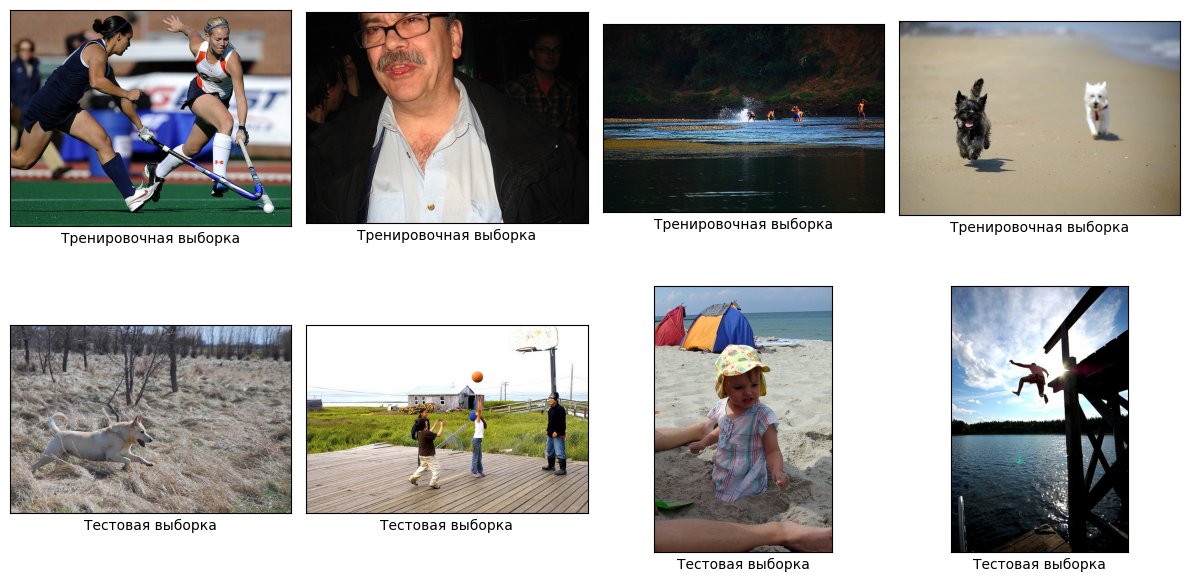

In [19]:
fig = plt.figure(figsize=(12,12))
# Визуализация тренировочных фото
for i in range(4):
    fig.add_subplot(4, 4, i+1)
    image = Image.open(Path(PATH, 'train_images', train_image[i]))
    plt.imshow(image)
    plt.xlabel('Тренировочная выборка')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
# Визуализация тестовых фото
for i in range(4):
    fig.add_subplot(4, 4, i+5)
    image = Image.open(Path(PATH, 'test_images', test_image[i]))
    plt.imshow(image)
    plt.xlabel('Тестовая выборка')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

В папках с тренировочными и тестовыми данными содержатся изображения различного размера. Также в этих папках содержатся изображения с детьми, которые, согласно условиям ТЗ, необходимо исключить.

### 1.5 Заключение по загрузке и обзору данных

- Имеющиеся в нашем распоряжении данные загружены и успешно прочитаны.
- Формат загруженных данных соответствует ожиданиям.
- Явных дубликатов и пропущенных значений в данных не обнаружено.
- Среди изображений встречаются фотографии,попадающие под ограничения - их необходимо исключить из датасета на следующих этапах

## 2 Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


### 2.1 Агрегация оценок экспертов

Для агрегации экспертных оценок будем использовать среднее значение голосов экспертов. Агрегированную оценку сохраним в новом столбце.

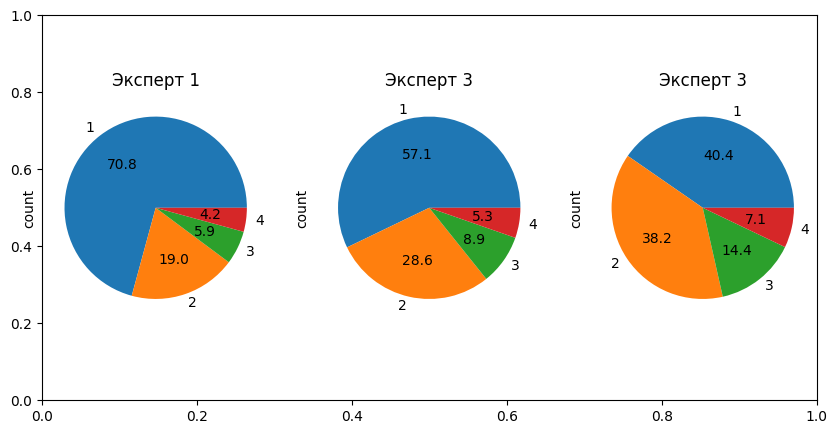

In [20]:
# Построим диаграммы распределений результатов голосования каждого эксперта

plt.subplots(figsize=(10, 5))
plt.subplot(1, 3, 1)
expert_annotations['exp1'].value_counts().plot(kind='pie', y= 'exp1', autopct='%.1f')
plt.title('Эксперт 1')

plt.subplot(1, 3, 2)
expert_annotations['exp2'].value_counts().plot(kind='pie', y= 'exp2', autopct='%.1f')
plt.title('Эксперт 3')

plt.subplot(1, 3, 3)
expert_annotations['exp3'].value_counts().plot(kind='pie', y= 'exp3', autopct='%.1f')
plt.title('Эксперт 3')

plt.show()

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

Из представленных распределений видно, что первый эксперт - самый строгий - среди его оценок самый большой процент оценок несоответствия описания и изображения.

In [21]:
# Введем новый столбец - результирующую оценку по результатам работы трех экспертов
expert_annotations['exp_agg'] = expert_annotations[['exp1', 'exp2', 'exp3']].mean(axis = 1)
# Приведем оценки экспертов из системы 1-4 в систему 0-1
expert_annotations['exp_agg'] = (expert_annotations['exp_agg'] - 1)/3

In [22]:
expert_annotations.head(3)

image                     query_id  exp1  exp2  exp3  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2     1     1     1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2     1     1     2   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2     1     1     2   

    exp_agg  
0  0.000000  
1  0.111111  
2  0.111111

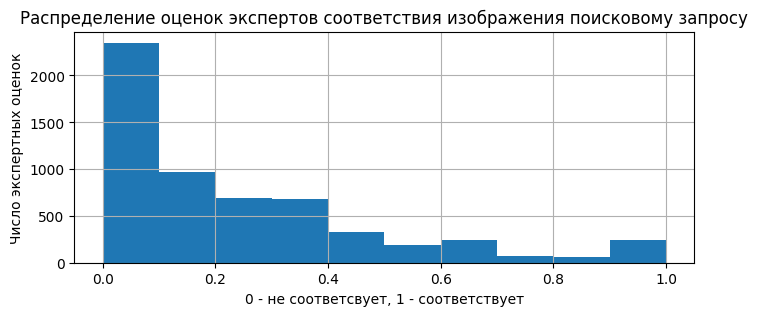

In [23]:
# Проверим, как распределена агрегрированная оценка трех экспертов
plt.figure(figsize=(8, 3))
expert_annotations['exp_agg'].hist()
plt.title(f'Распределение оценок экспертов соответствия изображения поисковому запросу')
plt.xlabel('0 - не соответсвует, 1 - соответствует')
plt.ylabel('Число экспертных оценок')
plt.show()

Агрегированная по результатам работы трех экспертов оценка распределена похожим образом с результатами голосования каждого эксперта. Перевод оценок из шкалы 1-4 в 0-1 произведен корректно.

Заметно, что большое количество пар изображение-текст отмечены как полностью не соответствующие друг другу.

### 2.2 Обзор краудсорсинговых оценок

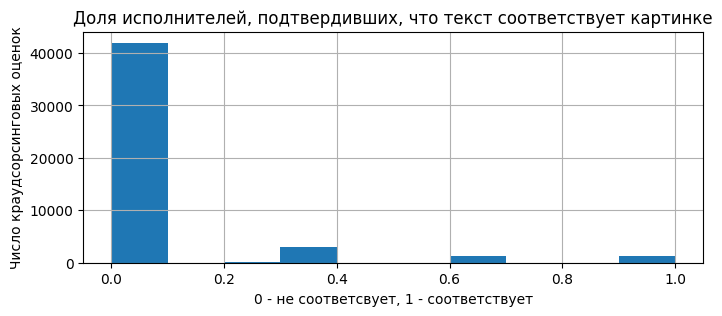

In [24]:
# Проверим, как распределены оценки среди краудсорсинговых данных
plt.figure(figsize=(8, 3))
crowd_annotations['agreed_ratio'].hist()
plt.title(f'Доля исполнителей, подтвердивших, что текст соответствует картинке')
plt.xlabel('0 - не соответсвует, 1 - соответствует')
plt.ylabel('Число краудсорсинговых оценок')
plt.show()

В краудсорсинговых данных также довольно велико число изображений, для которых изображение не соответствует описанию, по мнению краудсорсинговых сервисов.

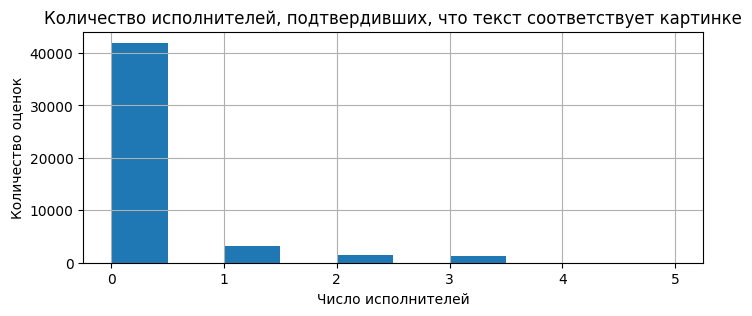

In [25]:
plt.figure(figsize=(8, 3))
crowd_annotations['number_agreed'].hist()
plt.title(f'Количество исполнителей, подтвердивших, что текст соответствует картинке')
plt.xlabel('Число исполнителей')
plt.ylabel('Количество оценок')
plt.show()

В большинстве случаев, согласно краудсорсинговым оценкам, текст не соответствет изображению.

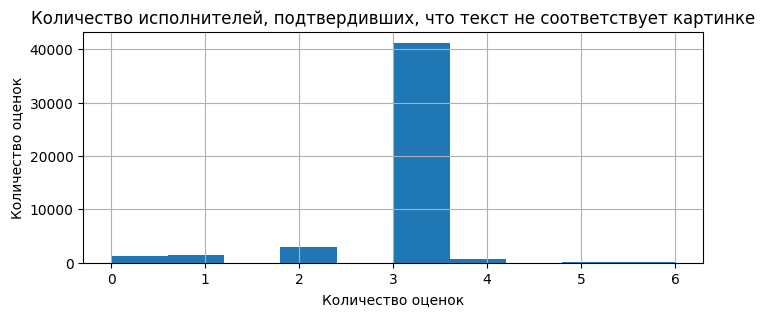

In [26]:
plt.figure(figsize=(8, 3))
crowd_annotations['number_disagreed'].hist()
plt.title(f'Количество исполнителей, подтвердивших, что текст не соответствует картинке')
plt.xlabel('Количество оценок')
plt.ylabel('Количество оценок')
plt.show()

Гистограмма в целом демонстрирует то же, что и предыдущая - в большинстве случаев голосование краудсорсинга склоняется к несоответствию изображения и текста.

### 2.3 Объединение оценок экспертов и краудсорсинга

В качестве результирующей оценки для тренировочного датафрейма будем использовать оценку экспертов по нескольким причинам:
- в данных краудсорсинга большое количество негативных оценок - по мнению краудсорсинга очень мало пар изображение-текст подходит друг другу.
- распределение оценок экспертов в диапазоне от 0 до 1 более равномерно.


In [27]:
# Добавим в тренировочный датасет целевую переменную - оценку соответствия картинки описанию - exp_agg
train_dataset= pd.merge(train_dataset, expert_annotations[['image', 'query_id', 'exp_agg']], how='outer', on=['image', 'query_id'])

In [28]:
# Проверим, не ошиблись ли с нормировкой при объединении краудсорсинговых и экспертных оценок
train_dataset['exp_agg'].max()

1.0

Максимальная оценка 1, как и должно быть.

In [29]:
# Проверим, совпадает ли длина
print ('Число строк после объединения: ', len(train_dataset))

Число строк после объединения:  5822


In [30]:
# Проверим, не появились ли пропущенные значения
train_dataset.isna().sum()

image         0
query_id      0
query_text    0
exp_agg       0
dtype: int64

In [31]:
# Переименуем столбец с целевой переменной
train_dataset = train_dataset.rename(columns={'exp_agg': 'score'})

In [32]:
train_dataset.head()

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2   

                                          query_text     score  
0  A young child is wearing blue goggles and sitt...  0.000000  
1  A girl wearing a yellow shirt and sunglasses s...  0.111111  
2    A man sleeps under a blanket on a city street .  0.111111  
3  A woman plays with long red ribbons in an empt...  0.222222  
4         Chinese market street in the winter time .  0.111111

In [33]:
# Посмотрим, для скольких уникальных изобрадений даны описания
len(train_dataset['image'].unique())

1000

В качестве итоговой оценки соответствия текста изображению было решено использовать оценки экспертов как более надежные.
Предварительно оценки экспертов переведены из шкалы 1-4 в шкалу 0-1, где наименьшее число характеризует полное несоответствие изображение и текста, а наибольшее - полное совпадение.
В тренировочный датасет был добавлен столбец с агрегированной оценкой экспертов.

### 2.4 Лемматизация текста

Для упрощения процесса векторизации описания изображений и очистки данных от нежелательного контента выполним лематизацию текста и визуализируем набор слов в тренировочном датафрейме в виде облака слов

In [34]:
nlp = spacy.load("en_core_web_sm")

In [35]:
# Набор стоп-слов
stopwords = set(nltk_stopwords.words('english'))

In [36]:
# Функция для очистки текста и лемматизации
def lemmatize_clear(text):
    text = text.lower()
    text = ' '.join(re.sub(r'[^a-zA-Z]', ' ', text).split())
    lemma = nlp(text)
    # Соберем обратно высказывания
    lemma = ' '.join([w.lemma_ for w in lemma])
    # Очистим лемматизированный текст от стоп-слов
    words = lemma.split()
    filtered_words = [word for word in words if word not in stopwords]
    final_lemma = ' '.join(filtered_words)
    return final_lemma

In [37]:
# Проверим, правильно ли работает лемматизация
sentence1 = "A The striped bats are hanging on their feet for best boys"
sentence2 = "you should be ashamed of yourself went worked"
df_my = pd.DataFrame([sentence1, sentence2], columns = ['text'])
print(df_my)

                                                text
0  A The striped bats are hanging on their feet f...
1      you should be ashamed of yourself went worked


In [38]:
print(df_my['text'].apply(lemmatize_clear))

0    striped bat hang foot good boy
1                   ashamed go work
Name: text, dtype: object


Функция для лемматизации работает правильно, применим ее к датасету.

In [39]:
# Лемматизируем датасет
train_dataset['lemm'] = train_dataset['query_text'].progress_apply(lemmatize_clear)

  0%|          | 0/5822 [00:00<?, ?it/s]

In [40]:
# Проверим результат лемматизации
train_dataset.head(3)

image                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2   

                                          query_text     score  \
0  A young child is wearing blue goggles and sitt...  0.000000   
1  A girl wearing a yellow shirt and sunglasses s...  0.111111   
2    A man sleeps under a blanket on a city street .  0.111111   

                                          lemm  
0  young child wear blue goggle sit float pool  
1        girl wear yellow shirt sunglass smile  
2                man sleep blanket city street

Тренировочный датасет лемматизирован, очищен от стоп-слов.

Визуализируем лемматизированные поисковые запросы в виде облака слов

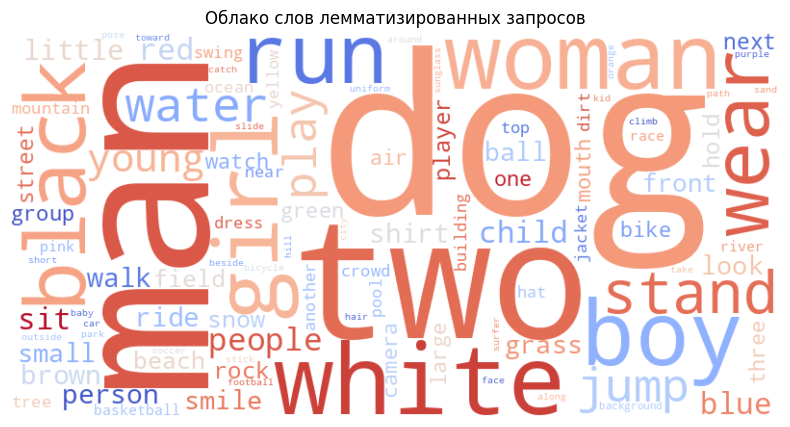

In [41]:
text = ' '.join(train_dataset['lemm'].astype(str).tolist())
text = ' '.join(word for word in text.split() if word not in stopwords)

back_color = 'white'
wordcloud = WordCloud(width=800, height=400, background_color=back_color, max_words=100,collocations=False,\
                      colormap='coolwarm').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.title("Облако слов лемматизированных запросов")

plt.show()

Из визуализации облака слов можно выделить наиболее часто встречающиеся слова в запросах. Довольно часто запросы связаны с собаками и людьми.

### **Заключение по исследовательскому анализу данных**

- На этапе исследовательского анализа данных выполнена агрегация оценок описаний изображений экспертами,
оценки экспертов из системы 1-4 в систему 0-1

- В процессе подготовки к агрегации отмечено, что из трех экспертов, оценивающих описания, оценки первого оказались наиболее строгими - он чаще всего отмечал, что изображение не соответсвует описанию.

- Отмечено , что согласно краудсорсинговым данным, также довольно велико число описаний, не соответствующих содержанию фотографии. Также в большинстве случаев голосование краудсорсинга склоняется к несоответствию изображения и текста.

- Принято решения в качестве итоговой оценки соответствия изображения тексту использовать агрегированную экспертную оценку.

- После создания общего датафрейма с объединенными оценками были удалены лишние столбцы, оставлен только один - с итоговыми оценками.

- Выполнена очистка и лемматизация текста запросов из тестового датафрейма, содержимое запросов визуализировано в виде облака слов.
Отмечены наиболее часто встречающиеся слова: dog, man, two, white, black, white, woman.

## 3. Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [42]:
# Создадим черный список для проверки данных
black_list = ['girl','boy','child','baby','kid','infant',\
              'toddler','newborn','teenager','junior','kiddie',
             'teenage']

In [43]:
# Функция отмечает подозрительный контент:
def restrictor(text):
    if [w for w in text.split() if w in black_list]:
        return True
    else:
        return False

In [44]:
# Проверим работу функции на тестовых данных
print(df_my['text'].apply(lemmatize_clear).apply(restrictor))

0     True
1    False
Name: text, dtype: bool


Функция работает корректно, применим ее к тренировочному датасету.

In [45]:
train_dataset['restriction'] = train_dataset['lemm'].apply(restrictor)

In [46]:
# Создадим список изображений, для которых есть ограничения
restriction_list = train_dataset.loc[train_dataset['restriction'] == True, 'image'].unique()
# Посмотрим, сколько изображений попадает под ограничения
total_img = len(train_dataset['image'].unique())
print(f'Под ограничения попало {len(restriction_list)} изображений из {total_img}')

Под ограничения попало 725 изображений из 1000


Поскольку одному изображению доступно несколько описаний, некоторые из которых могут не содержать слова про детей, на основе созданного списка с подозрительными изображениями, отметим все подозрительные изображения в тренировочном датасете.

In [47]:
# отметим все подозрительные изображения
train_dataset['restriction'] = train_dataset['image'].apply(lambda x: True if x in restriction_list else False)

In [48]:
# Посмотрим, сколько осталось описаний в тренировочном датасете.
len(train_dataset.loc[train_dataset['restriction'] == False])

1434

In [49]:
# Удалим лишние столбцы
train_dataset = train_dataset.loc[train_dataset['restriction'] == False, ['image', 'query_id', 'lemm','score']]


In [50]:
train_dataset.head()

image                     query_id  \
61  114051287_dd85625a04.jpg  3220126881_b0a4f7cccb.jpg#2   
62  114051287_dd85625a04.jpg  3281078518_630a7a7f4f.jpg#2   
63  114051287_dd85625a04.jpg  3530843182_35af2c821c.jpg#2   
64  114051287_dd85625a04.jpg   434792818_56375e203f.jpg#2   
65  114051287_dd85625a04.jpg   791338571_7f38510bf7.jpg#2   

                                                 lemm     score  
61                         two man woman smile camera  0.000000  
62  many white puppy eat food near several brown r...  0.000000  
63                   man sunglass woman hat front car  0.222222  
64  man woman look back camera stand front red art...  0.000000  
65                        red car park next cow field  0.111111

#### **Заключение по проверке данных**

Тестовые данные очищены от подозрительного контента.

В процессе очистки под ограничения попали 725 изображений из 1000.

При этом тренировочный датафрейм уменьшился с 5822 записей до 1434.

## 4. **Векторизация изображений**

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

Для векторизации изображений будет использована сверточная сеть со структурой ResNet50 без "верхушки" и с заморозкой весов.

Также на этапе подготовки данных приведем изображения в датафрейме к единому размеру - 224х224 и выполним их масштабирование.

Создадим функцию-загрузчик изображений и проверим его работу

In [51]:
# Функция для загрузки тренировочных данных
def load_train(path=PATH):

    train_datagen = ImageDataGenerator(
        horizontal_flip=True,
        rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=train_dataset,
        directory=path + '/train_images',
        x_col='image',
        y_col='score',
        target_size=(224, 224),
        batch_size=32,
        class_mode='input',
        seed=42)

    return train_gen_flow

Found 1434 validated image filenames.


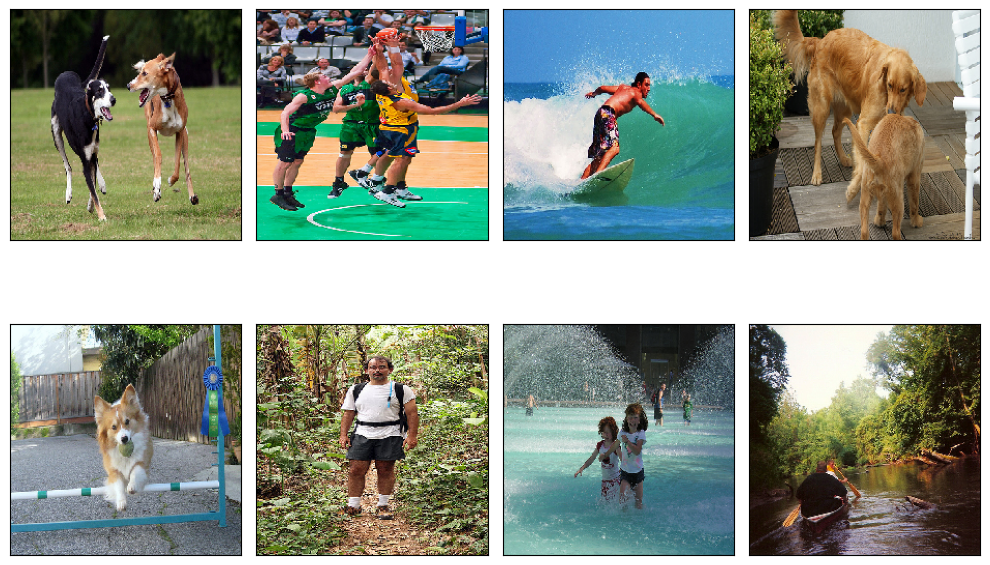

In [52]:
# Проверка работы загрузчика тренировочных данных
flow_train = load_train()
features, target = next(flow_train)

fig = plt.figure(figsize=(10,10))
for i in range(8):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

Несмотря на довольно строгую фильтрацию на предыдущих этапах в выдаче загрузчика пристутствуют изображения, которые должны были попасть под ограничения. Это может быть связано как с недостаточно корректными описаниями изображений, так и с недостаточно жетскими условиями фильтрации

In [53]:
# Создание модели
def create_model(input_shape=(224, 224, 3)):
    # Будем пользоваться структурой ResNet50 без "головы"
    backbone = ResNet50(weights='imagenet',
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())

    optimizer = Adam(learning_rate=0.0001)

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [54]:
# Создадим функцию для векторизации изображений
def image_vector(model, train_data):
    img_vector = model.predict(train_data)
    return img_vector

In [55]:
# Получим векторное представление тренировочных изображений
image_vectors = image_vector(create_model(), load_train())

Found 1434 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


45/45 ━━━━━━━━━━━━━━━━━━━━ 239s 5s/step


In [56]:
# Проверим размерность полученного массива с векторами
image_vectors.shape

(1434, 2048)

С использованием предобученной структуры ResNet50 без "верхушки" изображения из тренировочной выборки масштабированы и векторизованы.

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [57]:
# Загрузка предобученной модели и токенизатора BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

# Перевод модели в режим оценки
bert_model.eval()

# Функция для преобразования текста в вектор через BERT
def get_bert_vector(text, tokenizer, mdl):
    # Токенизация и преобразование в тензор
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    with torch.no_grad():
        outputs = mdl(**inputs)
    # Используем среднее по последнему скрытому состоянию (последний слой BERT)
    last_hidden_states = outputs.last_hidden_state
    return torch.mean(last_hidden_states, dim=1).squeeze().numpy()

# Применяем BERT к каждому тексту
bert_vectors = np.array([get_bert_vector(text, tokenizer, bert_model) for text in train_dataset['lemm']])

# Проверим размерность получившихся векторов
print('Размерность результата векторизации текстов', bert_vectors.shape)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Размерность результата векторизации текстов (1434, 768)


Размерность совпадает с ожидаемой, можно приступать к объединению векторов

## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [58]:
# Объединяем эмбединги изображений и их описаний
X = np.concatenate((image_vectors, bert_vectors), axis=1)
X.shape


(1434, 2816)

In [59]:
y = np.array(train_dataset['score'])

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

### 6.1 Подготовка данных

In [60]:
# Разбиваем датасет так, что строки с одинаковым значением 'image' будут содержаться либо в тестовом, либо в тренировочном датасете.
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=RANDOM_STATE)
train_indices, test_indices = next(gss.split(X=X, y=y, groups=train_dataset['image']))

In [61]:
# Формирование тренировочной и тестовой выборок
X_train, X_test = X[train_indices], X[test_indices]
y_train, y_test = y[train_indices], y[test_indices]

In [62]:
# Масштабирование данных
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Данные разделены на тренировочную и тестовую выборки.
Протестируем несколько моделей машинного обучения и выберем оптимальный вариант.

### 6.2 Выбор метрики качества

Целью создания модели машинного обучения в данной задачи является решение задачи регрессии и предсказание оценки, которую дали эксперты паре изображение-описание.
Для решения данной задачи лучше всего подойдут средняя абсолютная ошибка (MAE), среднеквадратическая ошибка (RMSE) или среднюя квадратическая ошибка MSE.

В качестве основной метрики для данной задачи выберем MAE - данная метрика менее чувствительна к выбросам в данных и более доступна для интерпретации в процессе анализа качества моделей.

### 6.3 Обучение модели линейной регрессии

In [63]:
model = LinearRegression(n_jobs=-1)
model.fit(X_train, y_train)
mean_absolute_error(y_test, model.predict(X_test))

0.7439899174546718

Модель линейной регрессии довольно сильно ошибается в предсказаниях.

### 6.4 Обучение модели градиентного бустинга
В качестве второй модели используем CatBoostRegressor

In [64]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
import math

In [65]:
model = CatBoostRegressor(learning_rate=0.3, n_estimators=50, depth=7, random_state = RANDOM_STATE, logging_level='Silent')

In [66]:
model.fit(X_train, y_train)
predictions = model.predict(X_train)
mae = mean_absolute_error(y_test, model.predict(X_test))

In [67]:
mae

0.24092786384258918

Модель градиентного бустинга показала весьма достойное значение метрики.
Проверим ее работу на тестовой выборке.

### 6.5 Создание нейросетевой модели

In [68]:
X_train.shape

(1001, 2816)

In [69]:
NN = Sequential()
NN.add(Dense(2816, input_shape=(2816,), activation='relu'))
NN.add(BatchNormalization())
NN.add(Dense(1408, activation='relu'))
NN.add(BatchNormalization())
NN.add(Dense(256, activation='relu'))
NN.add(BatchNormalization())
NN.add(Dense(1, activation='relu'))

optimizer = Adam(learning_rate=0.001)

NN.compile(optimizer=optimizer, loss='mean_squared_error',
            metrics=[tf.keras.metrics.MeanAbsoluteError()])
#neg_mean_absolute_error
NN.build()

NN.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2816)           │     7,932,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2816)           │        11,264 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1408)           │     3,966,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1408)           │         5,632 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       360,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,277,889 (46.84 MB)

 Trainable params: 12,268,929 (46.80 MB)

 Non-trainable params: 8,960 (35.00 KB)

In [70]:
NN.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=32, epochs=30,
    verbose=2, shuffle=True
    )

Epoch 1/30
32/32 - 8s - 255ms/step - loss: 0.9843 - mean_absolute_error: 0.5530 - val_loss: 0.3059 - val_mean_absolute_error: 0.3786
Epoch 2/30
32/32 - 9s - 267ms/step - loss: 0.1707 - mean_absolute_error: 0.2958 - val_loss: 0.2885 - val_mean_absolute_error: 0.3713
Epoch 3/30
32/32 - 6s - 186ms/step - loss: 0.1432 - mean_absolute_error: 0.2599 - val_loss: 0.1437 - val_mean_absolute_error: 0.2626
Epoch 4/30
32/32 - 5s - 143ms/step - loss: 0.1233 - mean_absolute_error: 0.2415 - val_loss: 0.1420 - val_mean_absolute_error: 0.2680
Epoch 5/30
32/32 - 6s - 174ms/step - loss: 0.1095 - mean_absolute_error: 0.2270 - val_loss: 0.1364 - val_mean_absolute_error: 0.2646
Epoch 6/30
32/32 - 10s - 300ms/step - loss: 0.0965 - mean_absolute_error: 0.2133 - val_loss: 0.1294 - val_mean_absolute_error: 0.2557
Epoch 7/30
32/32 - 5s - 165ms/step - loss: 0.0958 - mean_absolute_error: 0.2106 - val_loss: 0.1266 - val_mean_absolute_error: 0.2519
Epoch 8/30
32/32 - 11s - 342ms/step - loss: 0.0916 - mean_absolute_e

По результатам обучения нейросетевая модель демонстрирует наилучший показатель точности - метрика MAE составила 0.14 на тестовой выборке. Однако, не исключено, что подобный показатель связан с переобучением модели.

### 6.6 Предсказания с помощью константной модели



In [71]:
model = DummyRegressor(strategy='median')
model.fit(X_train, y_train)
mae = mean_absolute_error(y_test, model.predict(X_test))
mae

0.23582242750833976

Значение метрики для модели, предсказывающей случайное значение оказался соизмерим с метрикой модели градиентного бустинга, однако выше чем для нейронной сети.

Это вселяет сдержанный оптимизм по поводу качества работы нейросетевой модели.

### 6.6 Заключение по обучению моделей

Для предсказания оценки соответствия изображения описанию были обучены на тестовых данных четыре модели - линейной регрессии, градиентного бустинга, нейронная модель и константная модель.

По результатам обучения наилучший показатель качетсва продемонстрировала нейронная модель МО: MAE = 0.14

Именно она и будет использована для работы с тестовыми данными.

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

### 7.1 Загрузка изображений

In [72]:
# Функция для загрузки тестовых данных
def load_test(path=PATH):

    test_datagen = ImageDataGenerator(
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=test_images,
        directory=path + '/test_images',
        x_col='image',
        y_col=None,
        target_size=(224, 224),
        batch_size=32,
        class_mode='input',
        seed=SEED)

    return test_gen_flow

Found 100 validated image filenames.


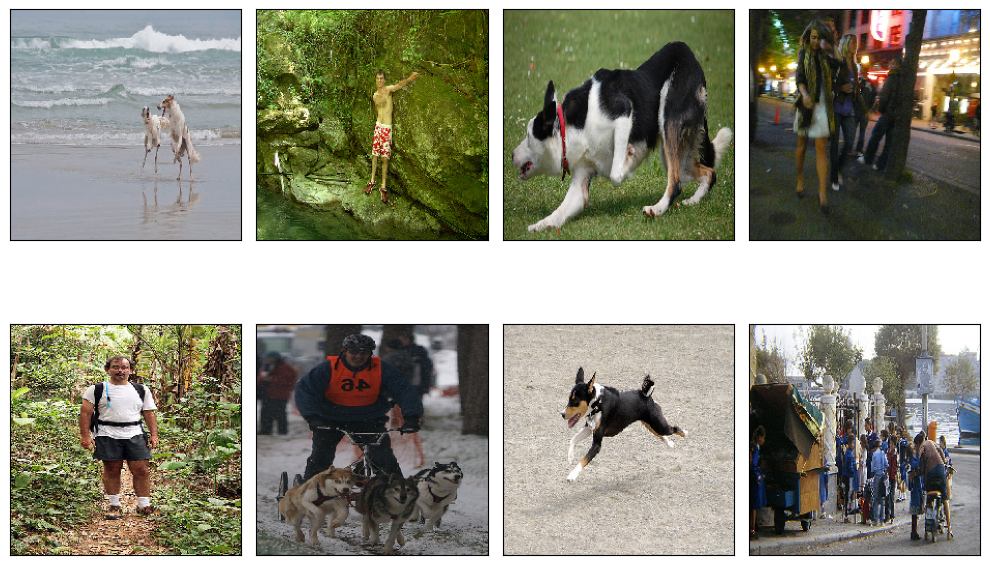

In [73]:
# Проверка работы загрузчика тренировочных данных
flow_test = load_test()
features, target = next(flow_train)

fig = plt.figure(figsize=(10,10))
for i in range(8):
    fig.add_subplot(3, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
plt.show()

Загрузчик тестовых данных функционирует корректно, можно приступать к формированию эмбеддингов.

### 7.2 Формирование эмбеддингов для тестовых изображений

In [74]:
test_embeddings = image_vector(create_model(), load_test())
# Проверим размернойсть полученных векторов
test_embeddings.shape

Found 100 validated image filenames.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


4/4 ━━━━━━━━━━━━━━━━━━━━ 22s 4s/step


(100, 2048)

Размерность полученных данных соответствует ожиданиям - в папке с тестовыми данными содержится 100 изображений

### 7.3 Выбор случайных запросов и вывод релевантного изображения

In [75]:
# Формируем 10 случайных запросов
queries = test_queries.sample(10)
# Лемматизируем текст запросов
queries['lemm'] = queries['query_text'].apply(lemmatize_clear)
# Отмечаем наличие запрещенного контента
queries['restriction'] = queries['lemm'].apply(restrictor)


 This image is unavailable in your country in compliance with local laws. 

Обработка изображения


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


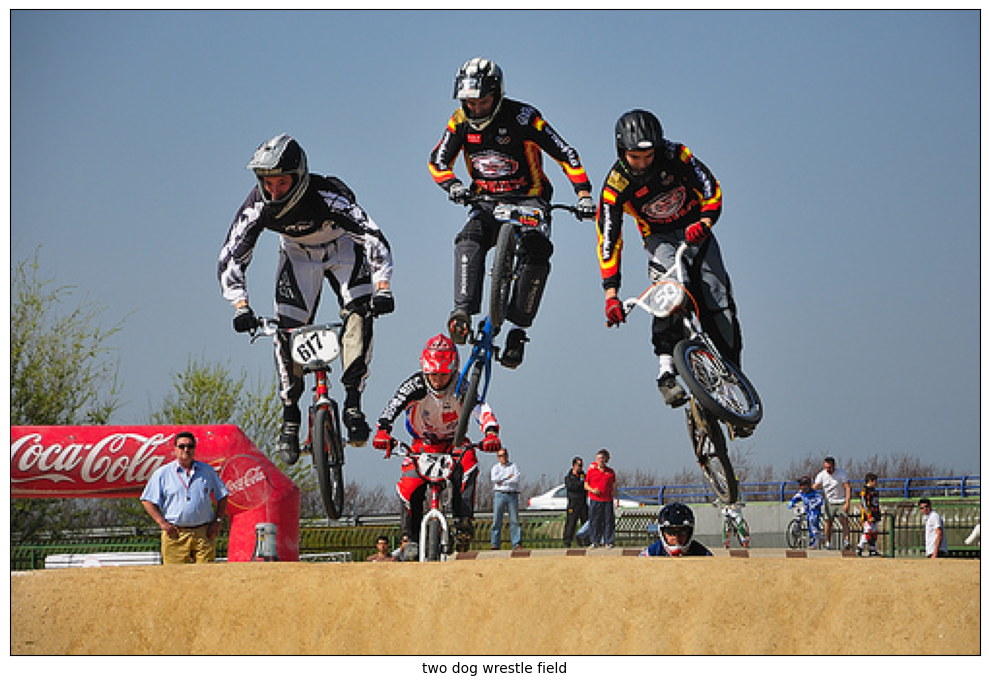

Обработка изображения
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


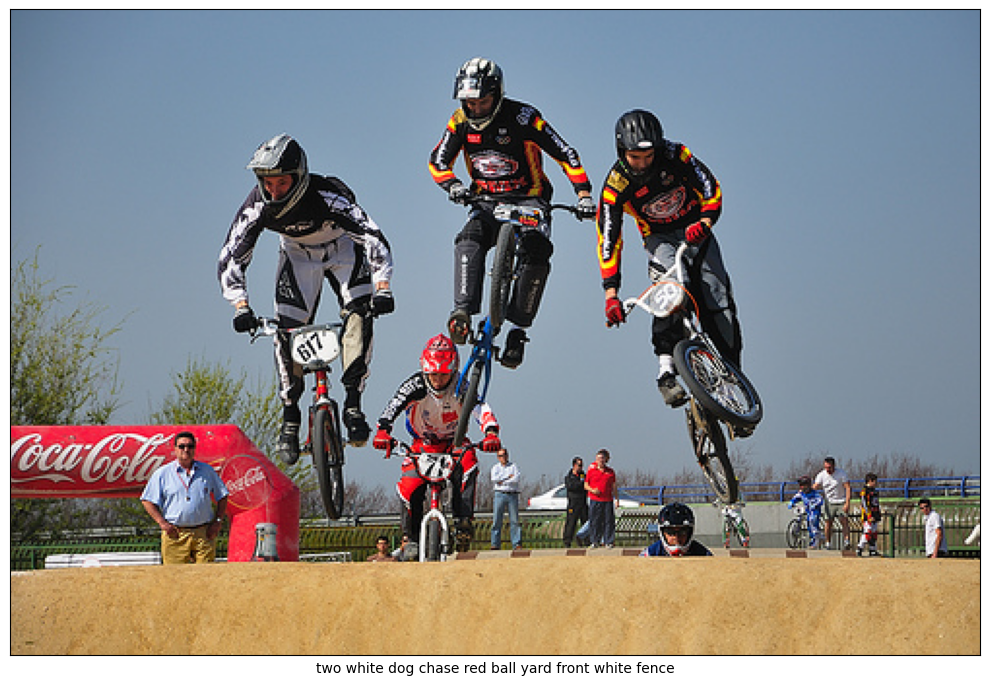


 This image is unavailable in your country in compliance with local laws. 


 This image is unavailable in your country in compliance with local laws. 


 This image is unavailable in your country in compliance with local laws. 


 This image is unavailable in your country in compliance with local laws. 


 This image is unavailable in your country in compliance with local laws. 

Обработка изображения
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


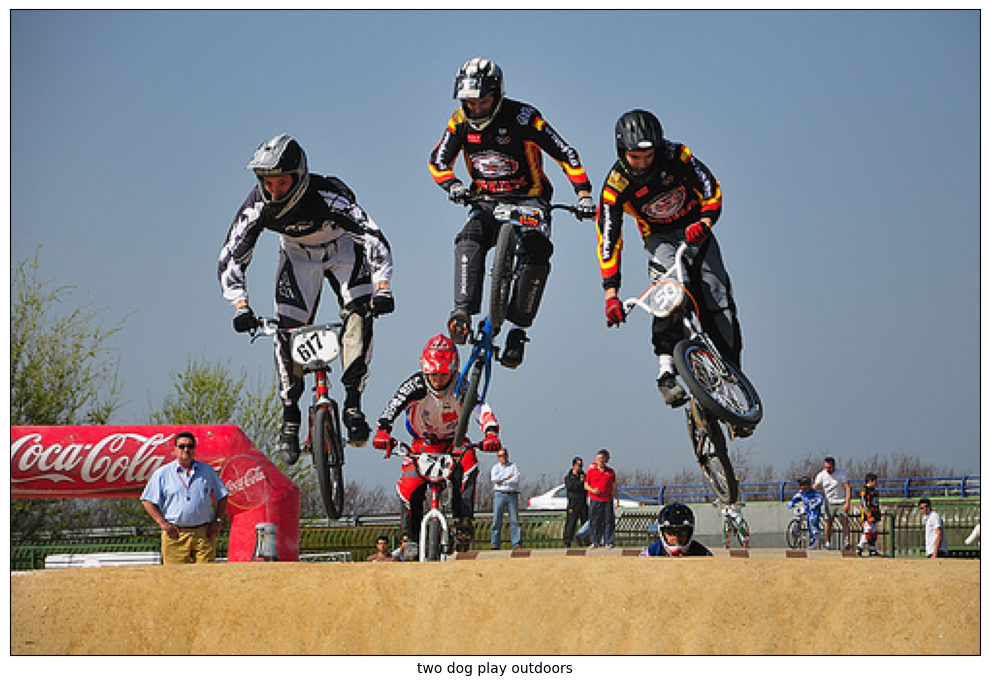

Обработка изображения
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


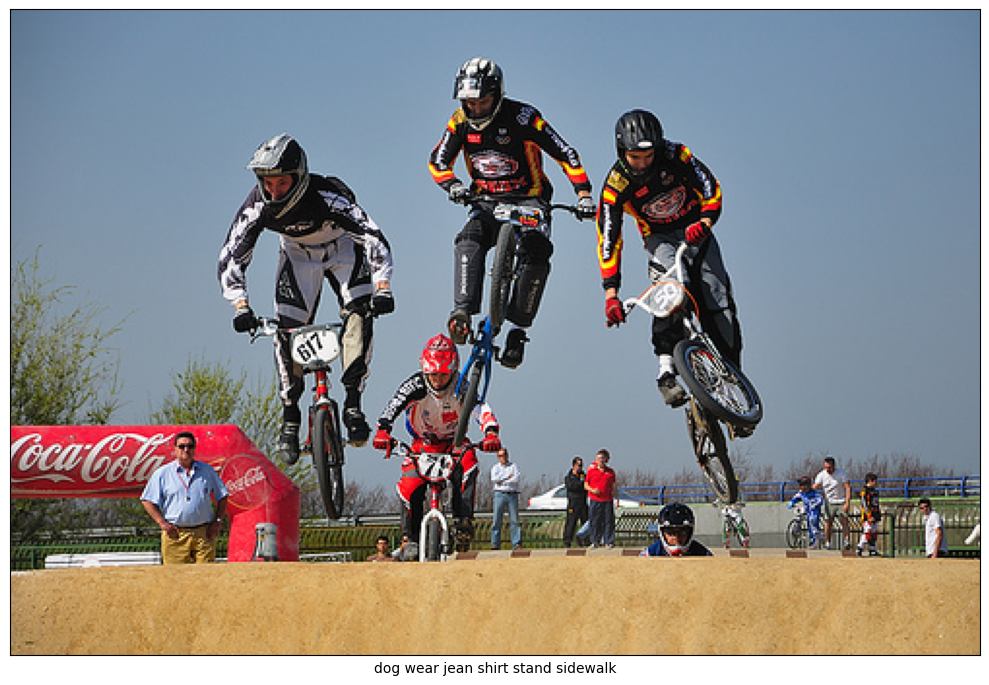

In [76]:
# Напишем инструмент для проверки работы предсказательной системы
for index in queries.index:
  if queries.loc[index,'restriction'] == True:
    print('\n This image is unavailable in your country in compliance with local laws. \n')
  else:
    print('Обработка изображения')
    # Формируем эмбеддинг лемматизированного запроса
    bert_vectors = get_bert_vector(queries.loc[index,'lemm'], tokenizer, bert_model)
    # Объединим эмбеддинги изображений и лемматизированных запросов
    X = np.concatenate((
            test_embeddings,
            np.resize(bert_vectors, (test_embeddings.shape[0],768))),
            axis=1)
    # Масштабирование векторов
    X = scaler.transform(X)
    # Предсказания оценки соответствия
    predictions = NN.predict(X) #получаем предсказания оценок экспертов

    df = pd.concat((test_images, pd.Series(np.reshape(predictions, (predictions.shape[0],)), name='pred')), axis=1) #добавляем оценки к номерам картинок
    # Выберем изображение с наивысшей предсказанной оценкой
    top = list(df.sort_values(by='pred', ascending=False)['image'].head(3))
    top_score = list(df.sort_values(by='pred', ascending=False)['pred'].head(3))

    fig = plt.figure(figsize=(10,10))
    image = Image.open(Path(PATH, 'test_images', top[0]))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(queries.loc[index,'lemm'])
    plt.tight_layout()
    plt.show()


Содержимое изображений сильно отличается от смысла запроса.
Кроме того, в изображениях, рекомендуемых моделью встречаются картинки, которые должны были попасть под ограничения. Скорее всего,это вызвано тем, что для тестовых данных не проводилась чистка от изображений с ограничениями, подобно той, что делалась для тренировочных данных.

Причины такого сильного расхождения запросов и выдаваемых изображений может быть связано с некорректной векторизацией пары изображение-запрос или другими недостатками при формировании эмбеддингов.

## 8 Заключение

Целью данной работы было создание модели машинного обучения, котороая позволила бы на основе поисковых запросов возвращать наиболее подходящее по содержанию изображение.

При создании данного инструмента необходимо было учитывать юридические ограничения и исключить из анализа и выдачи изображения с детьми.

Для обучения модели использовался датасет, содержащий 1000 уникальных изображений. Каждому изображению соответсвовало несколько описаний, при этом качество соответствия описания изображению оцценивалось как экспертами, так и краудсорсинговым сервисом.

Анализ данных показал, что и эксперты и краудсорсинг демонстрируют низкую удовлетворенность качеством соответствия описания изображений. По результатам анализа оценок для обучения моделей было решено использовать оценки экспертов как более надежные.

Для удовлетворения требованиям юридических ограничений из тренировочного датасета были удалены все изображения и запросы, содержащие упоминания детей.
Это значительно сократило обучающую выборку.

Однако, как показала практика, выполненная фильтрация не позволила полностью избавиться от содержимого, попадающего под ограничения. Это может быть связано как с недостаточно строгой фильтрацией, так и с некачественной разметкой датафрейма.

После векторизации изображений и соответствующих им описаний были обучены четыре модели машинного обучения: линейная регрессия, градиентный бустинг, нейронная сеть и константная модель.

В качестве метрики качества использовалась MAE, как менее подверженная выбросам в данных.

Лучший показателькачетва MAE = 0.14 был достигнут с использованием нейросетевой модели.

Работа данной модели была проверена на тестовой выборке путем сопоставления содержимого 10 случайных запросов и содержанием рекомендуемой картинки.

Содержимое изображений сильно отличается от смысла запроса.

Причины такого сильного расхождения запросов и выдаваемых изображений может быть связано как с переобучением модели на тестовых аднных, так и с особенностями векторизации пары изображение-запрос или другими недостатками при формировании эмбеддингов.

В текущем состоянии предложенная модель не может быть использована для адекватного поиска по изображениям.

Возможно, ее показатели могут быть улучшены при обучении на более качественном датасете.

## 9 Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Проверены экспертные оценки и краудсорсинговые оценки
- [x]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [x]  Изображения векторизованы
- [x]  Текстовые запросы векторизованы
- [x]  Данные корректно разбиты на тренировочную и тестовую выборки
- [x]  Предложена метрика качества работы модели
- [x]  Предложена модель схожести изображений и текстового запроса
- [x]  Модель обучена
- [x]  По итогам обучения модели сделаны выводы
- [x]  Проведено тестирование работы модели
- [x]  По итогам тестирования визуально сравнили качество поиска